##Classification of NIH X-Ray Images using Vision Transformer, SqueezeNet (Transfer Learning) and CNN - Using Loss Curves and Grad CAM to understand learning

This Jupyter Notebook is a comprehensive guide on how to perform and evaluate several models and choose the one which is right for you!


---
*  CNN with 3 layers on 28*28 images with 1 channel
*   SqueezeNET - Transfer Learning 224*224 image and 3 channels
*   VisionTransformer Custom Made 28*28 with 1 channel


GradCAM for the CNN.





In [ ]:
!nvidia-smi

Thu Dec 12 18:02:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

#### Install Libraries

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchsummary import summary


##Dataset

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=6c81e7ea9e87cc311e0bb3b1cceaaceb6b51bb4240a01e24114706211ade09c1
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
data_flag = 'chestmnist'
download = True

NUM_EPOCHS = 10
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
class_names = info['label']

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
print(info)

{'python_class': 'ChestMNIST', 'description': 'The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/chestmnist.npz?download=1', 'MD5': '02c8a6516a18b556561a56cbdd36c4a8', 'url_64': 'https://zenodo.org/records/10519652/files/chestmnist_64.npz?download=1', 'MD5_64': '9de6cd0b934ebb5b7426cfba5efbae16', 'url_128': 'https://zenodo.org/records/10519652/files/chestmnist_128.npz?download=1', 'MD5_128': 'db107e5590b27930b62dbaf558aebee3', 'url_224': 'https://zenodo.org/records/10519652/files/chestmnist_224.npz?download=1', 'MD5_224': '45bd33e6f06c3e8cdb481c74a89152aa', 'task': 'multi-label, binary-class', 'label': {'0': 'atelectasis', '1': 'cardiomegaly', '2'

### Preprocessing for CNN and Vision Transformer Simple

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)


# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 82.8M/82.8M [00:04<00:00, 20.3MB/s]


Using downloaded and verified file: /root/.medmnist/chestmnist.npz


Class names: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
Scalar label for image 0: 0
Scalar label for image 1: 0
Scalar label for image 2: 0
Scalar label for image 3: 1
Scalar label for image 4: 0
Scalar label for image 5: 8
Scalar label for image 6: 0
Scalar label for image 7: 0
Scalar label for image 8: 3
Scalar label for image 9: 0
Scalar label for image 10: 0
Scalar label for image 11: 0
Scalar label for image 12: 0
Scalar label for image 13: 0
Scalar label for image 14: 0
Scalar label for image 15: 1


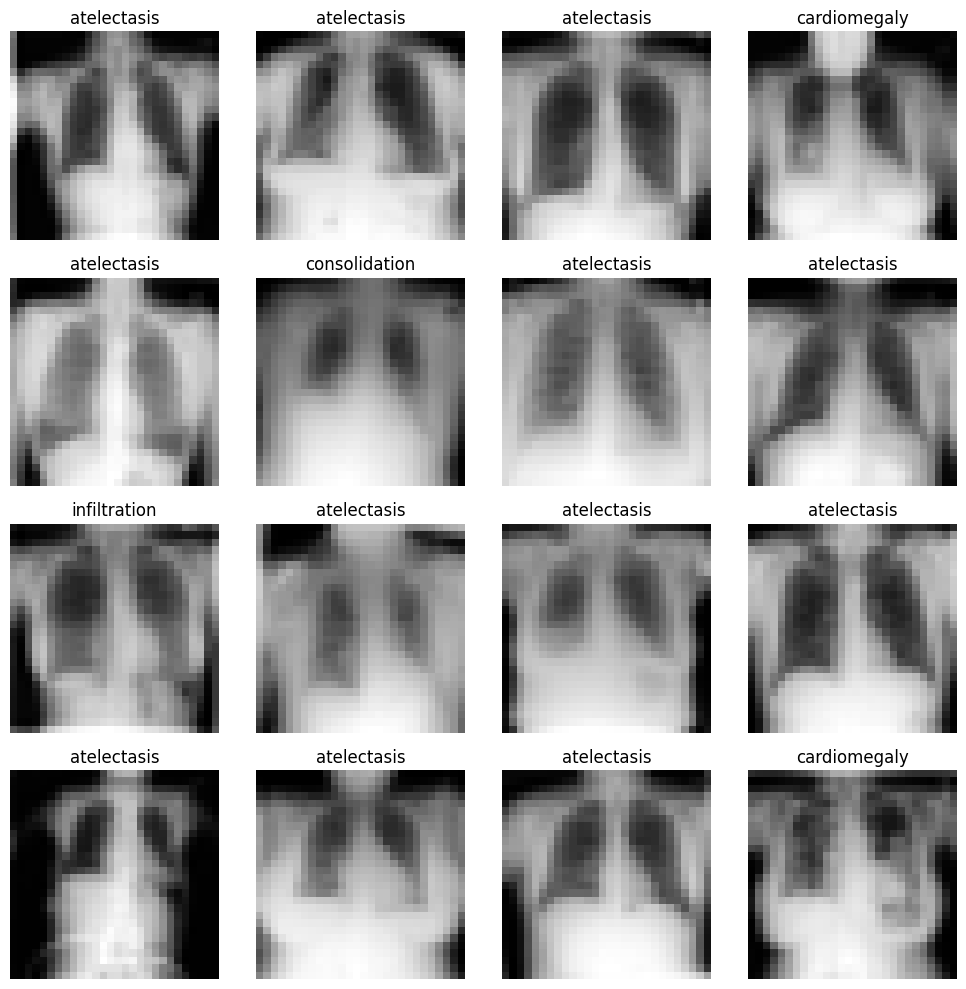

In [ ]:
def display_images(images, labels, class_names):
    print(f"Class names: {class_names}")  # Debugging
    plt.figure(figsize=(10, 10))

    num_images = len(images)
    grid_size = min(num_images, 16)

    for i in range(grid_size):  # Only loop through the available images in the batch
        plt.subplot(4, 4, i + 1)  # Arrange images in a 4x4 grid
        plt.imshow(images[i].squeeze(), cmap="gray")

        # Convert one-hot encoded label
        scalar_label = labels[i].argmax().item()
        print(f"Scalar label for image {i}: {scalar_label}")

        # Map to class name using key
        scalar_label_str = str(scalar_label)  # Convert label to string for dictionary key
        if scalar_label_str in class_names:
            plt.title(class_names[scalar_label_str])
        else:
            plt.title("Unknown Class")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))
images = images.numpy().transpose((0, 2, 3, 1))  #

# Call the function
display_images(images, labels, class_names)


In [ ]:
# Access images and labels

transformed_image, transformed_label = train_dataset[0]  # Get the transformed image and label from the dataset
print(f"Transformed image shape: {transformed_image.shape}")
print(f"Transformed label shape: {transformed_label.shape}")


# Print the first few labels to see how they are structured
print(f'First few labels: {transformed_label[:10]}')

Transformed image shape: torch.Size([1, 28, 28])
Transformed label shape: (14,)
First few labels: [0 0 0 0 0 0 0 0 0 0]


In [ ]:
DataClass = getattr(medmnist, info['python_class'])

dataset = DataClass(split='train')

# Access images and labels
images, labels = dataset.imgs, dataset.labels

# Check the shapes
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

# Debugging
print(f'First few labels: {labels[:10]}')

Images shape: (78468, 28, 28)
Labels shape: (78468, 14)
First few labels: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
from collections import Counter
import numpy as np

class_counts = Counter()

# Iterate through the test_loader
for batch in test_loader:
    images, labels = batch
    labels = labels.cpu().numpy()

    for label_vector in labels:

        classes_present = np.where(label_vector == 1)[0]  # Get the indices of classes
        class_counts.update(classes_present)  # Update counts for the classes present


for class_id, count in class_counts.items():
    print(f"Class {class_id} ({class_names[str(class_id)]}): {count} images")

Class 3 (infiltration): 3938 images
Class 5 (nodule): 1335 images
Class 11 (fibrosis): 362 images
Class 1 (cardiomegaly): 582 images
Class 2 (effusion): 2754 images
Class 0 (atelectasis): 2420 images
Class 10 (emphysema): 509 images
Class 13 (hernia): 42 images
Class 4 (mass): 1133 images
Class 12 (pleural): 734 images
Class 7 (pneumothorax): 1089 images
Class 8 (consolidation): 957 images
Class 9 (edema): 413 images
Class 6 (pneumonia): 242 images


## Simple CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

class SimpleNet(nn.Module):
    def __init__(self, num_classes=14):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 12 * 12, 128),
            nn.Linear(128, num_classes)
        )
        self.gradients = None
        self.activations = None

        # Register full backward hook
        self._register_hook()

    def _register_hook(self):
        """Register full backward hook for the last convolutional layer."""
        conv_layer = self.conv_layers[3]  # Last convolutional layer

        def forward_hook(module, input, output):
            """Store activations from the last convolutional layer."""
            self.activations = output

        def full_backward_hook(module, grad_input, grad_output):
            """Store gradients from the last convolutional layer."""
            self.gradients = grad_output[0]

        # Register hooks
        conv_layer.register_forward_hook(forward_hook)
        conv_layer.register_full_backward_hook(full_backward_hook)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.classifier(x)

    def generate_gradcam(self, image, class_idx):
        """Generate Grad-CAM heatmap for a specific class."""
        # Forward and backward passes
        self.zero_grad()
        outputs = self(image)

        # For multi-label, use sigmoid and target specific class
        target = torch.sigmoid(outputs)[0, class_idx]
        target.backward()

        # Process gradients and activations
        gradients = self.gradients
        activations = self.activations

        # Global Average Pooling
        weights = torch.mean(gradients, dim=[2, 3])
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32, device=activations.device)

        for k, w in enumerate(weights[0]):
            cam += w * activations[0, k, :, :]

        # Normalize and apply ReLU
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam /= cam.max()

        # Convert to numpy and resize
        cam_np = cam.detach().cpu().numpy()
        cam_resized = cv2.resize(cam_np, (image.shape[2], image.shape[3]))

        return cam_resized

    def visualize_gradcam(self, image, class_idx, alpha=0.4):
        """Visualize Grad-CAM overlay."""
        # Generate heatmap
        cam = self.generate_gradcam(image, class_idx)

        # Prepare image for overlay
        img_np = image.squeeze().cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        img_np = (img_np * 255).astype(np.uint8)

        # Apply color map
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(heatmap, alpha, img_np.transpose(1, 2, 0), 1 - alpha, 0)

        return overlay

def plot_gradcam(model, image, class_idx):
    """Helper function to plot original image and Grad-CAM overlay."""
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')

    # Grad-CAM Overlay
    plt.subplot(1, 2, 2)
    plt.title(f'Grad-CAM for Class {class_idx}')
    overlay = model.visualize_gradcam(image, class_idx)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
simple_net =   SimpleNet(num_classes=14)

# Define loss function and optimizer
task = "multi-label, binary-class"
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(simple_net.parameters(), lr=0.001)

In [ ]:
print(len(train_loader))


2453


100%|██████████| 2453/2453 [00:39<00:00, 61.70it/s]


Epoch [1/10], Training Loss: 0.1780


100%|██████████| 2453/2453 [00:39<00:00, 62.25it/s]


Epoch [2/10], Training Loss: 0.1700


100%|██████████| 2453/2453 [00:39<00:00, 62.69it/s]


Epoch [3/10], Training Loss: 0.1672


100%|██████████| 2453/2453 [00:38<00:00, 62.96it/s]


Epoch [4/10], Training Loss: 0.1649


100%|██████████| 2453/2453 [00:39<00:00, 62.63it/s]


Epoch [5/10], Training Loss: 0.1625


100%|██████████| 2453/2453 [00:39<00:00, 62.44it/s]


Epoch [6/10], Training Loss: 0.1601


100%|██████████| 2453/2453 [00:38<00:00, 63.07it/s]


Epoch [7/10], Training Loss: 0.1579


100%|██████████| 2453/2453 [00:39<00:00, 62.39it/s]


Epoch [8/10], Training Loss: 0.1561


100%|██████████| 2453/2453 [00:39<00:00, 61.78it/s]


Epoch [9/10], Training Loss: 0.1541


100%|██████████| 2453/2453 [00:39<00:00, 61.68it/s]


Epoch [10/10], Training Loss: 0.1524


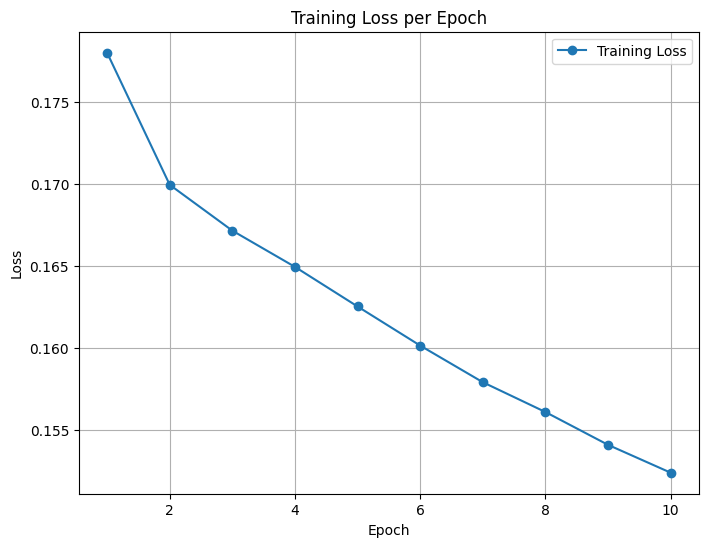

In [ ]:
NUM_EPOCHS = 10
train_losses = []  # List to store average training loss per epoch

for epoch in range(NUM_EPOCHS):
    simple_net.train()
    epoch_loss = 0.0  # Initialize epoch loss
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = simple_net(inputs)

        # Multi-class binary classification
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)  # Ensure targets are float for BCEWithLogitsLoss
            loss = criterion(outputs, targets)  # Calculate binary classification loss for each class independently

        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize the model

        epoch_loss += loss.item()  # Accumulate batch loss

    # Calculate average loss for the epoch
    average_loss = epoch_loss / len(train_loader)
    train_losses.append(average_loss)  # Append to list

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Training Loss: {average_loss:.4f}")

# Plot the loss per epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()



In [ ]:
torch.save(simple_net.state_dict(), 'trained_model_simple_net.pth')

In [ ]:
simple_net.load_state_dict(torch.load('/content/trained_model_simple_net.pth'))


simple_net.eval()

<ipython-input-13-75ff35a88926>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simple_net.load_state_dict(torch.load('/content/trained_model_simple_net.pth'))


SimpleNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4608, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=14, bias=True)
  )
)

In [ ]:
import numpy as np

found_positions = set()


for idx, label in enumerate(labels):

    ones_positions = np.where(label == 1)[0]

    # Check for positions that have not been found yet
    for pos in ones_positions:
        if pos not in found_positions:
            print(f"Image index {idx} has a 1 at label position {pos}")
            found_positions.add(pos)  # Mark the position as found

            # Stop searching if we've found all 14 positions
            if len(found_positions) == 14:
                break


    if len(found_positions) == 14:
        break




Image index 5 has a 1 at label position 3
Image index 5 has a 1 at label position 5
Image index 6 has a 1 at label position 7
Image index 6 has a 1 at label position 8
Image index 6 has a 1 at label position 10
Image index 8 has a 1 at label position 2
Image index 13 has a 1 at label position 1
Image index 24 has a 1 at label position 0
Image index 42 has a 1 at label position 6
Image index 62 has a 1 at label position 4
Image index 91 has a 1 at label position 12
Image index 108 has a 1 at label position 9
Image index 243 has a 1 at label position 11
Image index 388 has a 1 at label position 13


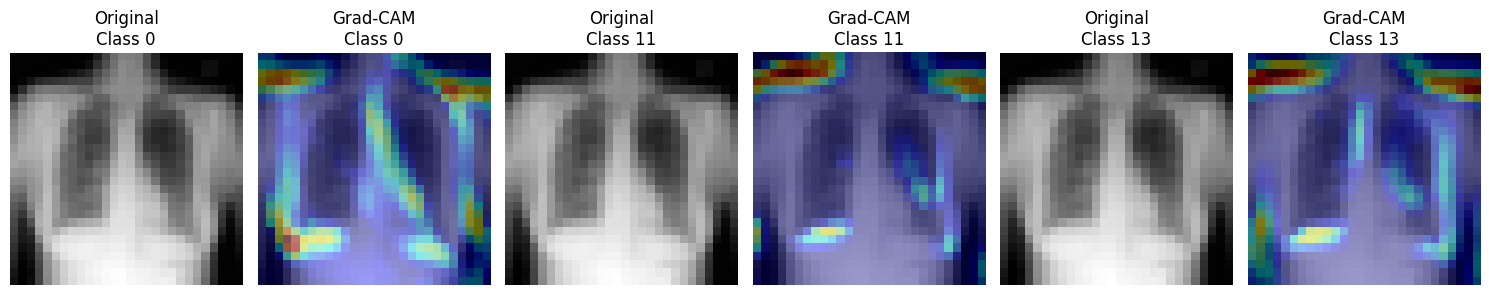

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Ensure the image tensor is in the correct format
def prepare_image_tensor(image):

    if not isinstance(image, np.ndarray):
        image = np.array(image)

    # Normalize the image
    image = (image - image.min()) / (image.max() - image.min())

    # Convert to tensor
    tensor = torch.from_numpy(image).float()
s
    tensor = tensor.unsqueeze(0).unsqueeze(0)

    return tensor

# Prepare the image tensor
image_tensor = prepare_image_tensor(images[1000])


# Find active classes
active_classes = np.where(labels[388] == 1)[0]


plt.figure(figsize=(15, 5))

for i, class_idx in enumerate(active_classes):

    plt.subplot(1, len(active_classes)*2, 2*i+1)
    plt.imshow(image_tensor.squeeze(), cmap='gray')
    plt.title(f'Original\nClass {class_idx}')
    plt.axis('off')

    # Grad-CAM overlay
    plt.subplot(1, len(active_classes)*2, 2*i+2)
    try:

        cam = simple_net.generate_gradcam(image_tensor, class_idx)


        img_np = image_tensor.squeeze().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())


        cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))


        cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())


        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)


        img_3channel = np.repeat(img_np[:, :, np.newaxis], 3, axis=2)
        img_3channel = (img_3channel * 255).astype(np.uint8)

        # Overlay
        overlay = cv2.addWeighted(heatmap, 0.4, img_3channel, 0.6, 0)

        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.title(f'Grad-CAM\nClass {class_idx}')
    except Exception as e:
        print(f"Error generating Grad-CAM for class {class_idx}: {e}")

    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
simple_net = simple_net.to(device)

def test_model(model, test_loader, threshold=0.5):
    model.eval()
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Ensure labels are floats
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)


            outputs = model(images)

            # Apply sigmoid to logits and threshold to get binary predictions
            predictions = (torch.sigmoid(outputs) > threshold).float()

            # Compute total correct predictions per batch
            batch_correct = (predictions == labels).sum().item()


            correct_predictions += batch_correct
            total_samples += labels.numel()  # Total number of elements in labels

    accuracy = 100 * correct_predictions / total_samples
    print(f"{test_loader} Accuracy: {accuracy:.2f}%")



# Training and Testing

test_model(simple_net, test_loader)
test_model(simple_net, train_loader_at_eval)

<torch.utils.data.dataloader.DataLoader object at 0x7ae2bd007610> Accuracy: 94.59%
<torch.utils.data.dataloader.DataLoader object at 0x7ae2bd005300> Accuracy: 95.01%


## Transfer Learning

Tried ResNET18, MobileNETV2 and SqueezeNET. Chose SqueezeNet for Computational efficiency and only did 3 epochs.

In [ ]:
BATCH_SIZE = 32

from torchvision.transforms.transforms import Resize
# preprocessing
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    torchvision.transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=train_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)


# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np


class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.base_model = models.squeezenet1_1(pretrained=True)  # Using SqueezeNet 1.1
        # Freeze all layers except the last one
        for param in self.base_model.parameters():
            param.requires_grad = False
        # Replace the last classifier layer
        self.base_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))  # 512 to num_classes

    def forward(self, x):
        return self.base_model(x)

num_classes = 14
transfer_squeezenet = TransferLearningModel(num_classes=num_classes)

def hook_fn(module, input, output):
    global feature_maps
    feature_maps = output

# Register the hook to the last convolutional layer (in SqueezeNet, it's 'features[-1]')
transfer_squeezenet.base_model.features[-1].register_forward_hook(hook_fn)

# Loss Definition
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(transfer_squeezenet.base_model.classifier[1].parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 47.0MB/s]


100%|██████████| 2453/2453 [21:16<00:00,  1.92it/s]


Epoch [1/3], Training Loss: 0.6948


100%|██████████| 2453/2453 [21:20<00:00,  1.92it/s]


Epoch [2/3], Training Loss: 0.6931


100%|██████████| 2453/2453 [21:23<00:00,  1.91it/s]


Epoch [3/3], Training Loss: 0.6931


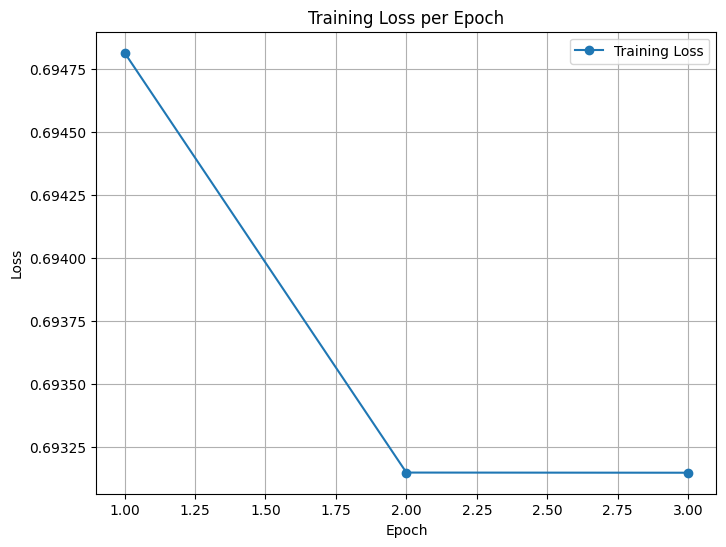

In [ ]:
NUM_EPOCHS = 3
train_losses = []  # List to store average training loss per epoch

for epoch in range(NUM_EPOCHS):
    transfer_squeezenet.train()
    epoch_loss = 0.0  # Initialize epoch loss
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()  # Zero the gradients

        outputs = transfer_squeezenet(inputs)
        targets = targets.to(torch.float32)  #
        loss = criterion(outputs, targets)

        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize the model

        epoch_loss += loss.item()  # Accumulate batch loss

    # Calculate average loss for the epoch
    average_loss = epoch_loss / len(train_loader)
    train_losses.append(average_loss)  # Append to list

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Training Loss: {average_loss:.4f}")

# Plot the loss per epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()



In [ ]:
torch.save(transfer_squeezenet.state_dict(), 'trained_model_transfer_squeezenet.pth')

In [ ]:
transfer_squeezenet.load_state_dict(torch.load('trained_model_transfer_squeezenet.pth'))

transfer_squeezenet.eval()

<ipython-input-131-57c8481a529a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transfer_squeezenet.load_state_dict(torch.load('trained_model_transfer_squeezenet.pth'))


TransferLearningModel(
  (base_model): SqueezeNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (3): Fire(
        (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (expand3x3_activation): ReLU(inplace=True)
      )
      (4): Fire(
        (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
        (squeeze_activation): ReLU(inplace=True)
        (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (expand1x1_activation): ReLU(inplace=True)
        (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transfer_squeezenet = transfer_squeezenet.to(device)

def test_model(model, test_loader, threshold=0.5):
    transfer_squeezenet.eval()
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in test_loader:

            labels = labels.float()
            images, labels = images.to(device), labels.to(device)


            outputs = model(images)  # Shape: (batch_size, num_labels)

            # Apply sigmoid to logits and threshold to get binary predictions
            predictions = (torch.sigmoid(outputs) > threshold).float()

            # Compute total correct predictions per batch
            batch_correct = (predictions == labels).sum().item()

            correct_predictions += batch_correct
            total_samples += labels.numel()  # Total number of elements in labels

    accuracy = 100 * correct_predictions / total_samples
    print(f"Accuracy: {accuracy:.2f}%")



test_model(transfer_squeezenet, test_loader)
test_model(transfer_squeezenet, train_loader_at_eval)

Accuracy: 94.74%
Accuracy: 94.86%


ResNet18's accuracy was 94.74% and same for squeezenet.

#### Vision Transformer

In [ ]:
BATCH_SIZE = 32

from torchvision.transforms.transforms import Resize
# preprocessing
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    torchvision.transforms.AugMix(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Lambda(lambda image: image.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=train_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)


# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import timm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils import data
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Resize

# Model setup
vit = timm.create_model('vit_base_patch16_224', pretrained=True)
num_ftrs = vit.head.in_features
vit.head = nn.Linear(num_ftrs, num_classes)  # Assuming train_dataset has the correct number of classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit = vit.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
NUM_EPOCHS = 3
train_losses = []  # List to store average training loss per epoch

for epoch in range(NUM_EPOCHS):
    vit.train()
    epoch_loss = 0.0  # Initialize epoch loss
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = vit(inputs)
        targets = targets.to(torch.float32)  # Ensure targets are float for BCEWithLogitsLoss
        loss = criterion(outputs, targets)  # Calculate binary classification loss for each class independently

        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize the model

        epoch_loss += loss.item()  # Accumulate batch loss

    # Calculate average loss for the epoch
    average_loss = epoch_loss / len(train_loader)
    train_losses.append(average_loss)  # Append to list

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Training Loss: {average_loss:.4f}")

# Plot the loss per epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()



  6%|▌         | 141/2453 [01:05<17:59,  2.14it/s]


KeyboardInterrupt: 

#### Training Our Own Vision Transformer

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)


# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        attn_output, attn_weights = self.attn(x, x, x, need_weights=True)
        x = x + attn_output
        x = self.norm1(x)
        x = x + self.mlp(x)
        x = self.norm2(x)
        return x, attn_weights

class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=64, num_heads=4, mlp_dim=128, num_classes=14, num_layers=6, dropout=0.3):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, (img_size // patch_size) ** 2 + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        self.encoder_layers = nn.ModuleList(
            [TransformerEncoder(embed_dim, num_heads, mlp_dim, dropout) for _ in range(num_layers)]
        )
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)

        attn_maps = []
        for layer in self.encoder_layers:
            x, attn_weights = layer(x)
            attn_maps.append(attn_weights)

        cls_output = x[:, 0]
        logits = self.head(cls_output)
        return logits, attn_maps


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
homemade_vit = VisionTransformer(num_classes=14).to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Multi-label binary classification loss
optimizer = optim.AdamW(homemade_vit.parameters(), lr=1e-4)

# Model Summary
print(homemade_vit)



Using device: cuda
VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (encoder_layers): ModuleList(
    (0-5): 6 x TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (head): Linear(in_features=64, out_features=14, bias=True)
)


In [ ]:
# Calculate total parameters for the VisionTransformer
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_parameters = count_parameters(homemade_vit)
print(f"Total trainable parameters: {total_parameters}")


Total trainable parameters: 206094


100%|██████████| 2453/2453 [00:59<00:00, 41.40it/s]


Epoch [1/10], Training Loss: 0.1955


100%|██████████| 2453/2453 [00:59<00:00, 41.57it/s]


Epoch [2/10], Training Loss: 0.1774


100%|██████████| 2453/2453 [00:59<00:00, 41.46it/s]


Epoch [3/10], Training Loss: 0.1753


100%|██████████| 2453/2453 [00:59<00:00, 41.28it/s]


Epoch [4/10], Training Loss: 0.1743


100%|██████████| 2453/2453 [00:59<00:00, 41.32it/s]


Epoch [5/10], Training Loss: 0.1733


100%|██████████| 2453/2453 [00:59<00:00, 41.52it/s]


Epoch [6/10], Training Loss: 0.1727


100%|██████████| 2453/2453 [00:59<00:00, 41.47it/s]


Epoch [7/10], Training Loss: 0.1722


100%|██████████| 2453/2453 [00:59<00:00, 41.29it/s]


Epoch [8/10], Training Loss: 0.1717


100%|██████████| 2453/2453 [00:59<00:00, 41.50it/s]


Epoch [9/10], Training Loss: 0.1713


100%|██████████| 2453/2453 [00:59<00:00, 41.27it/s]


Epoch [10/10], Training Loss: 0.1709


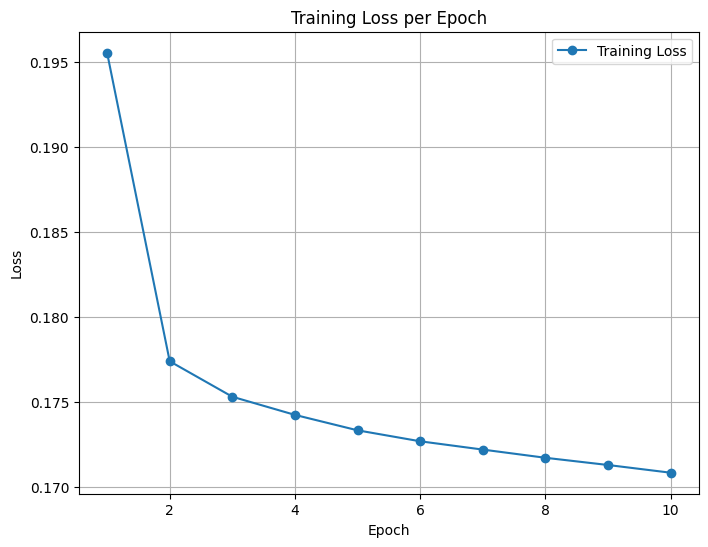

In [ ]:
NUM_EPOCHS = 10
train_losses = []  # List to store average training loss per epoch

for epoch in range(NUM_EPOCHS):
    homemade_vit = homemade_vit.to(device)


    homemade_vit.train()
    epoch_loss = 0.0  # Initialize epoch loss
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)  # Move inputs to the device (GPU/CPU)
        targets = targets.to(device)  # Move targets to the device (GPU/CPU)
        optimizer.zero_grad()

        # Forward pass
        outputs, _ = homemade_vit(inputs) # Only take logits not attention maps
        targets = targets.to(torch.float32)
        loss = criterion(outputs, targets)
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize the model

        epoch_loss += loss.item()  # Accumulate batch loss

    # Calculate average loss for the epoch
    average_loss = epoch_loss / len(train_loader)
    train_losses.append(average_loss)  # Append to list

    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Training Loss: {average_loss:.4f}")

# Plot the loss per epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid()
plt.show()



In [ ]:
torch.save(homemade_vit.state_dict(), 'trained_model_homemade_vit.pth')


In [ ]:
homemade_vit.load_state_dict(torch.load('trained_model_homemade_vit.pth'))

homemade_vit.eval()

<ipython-input-155-0bf0815b94b9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  homemade_vit.load_state_dict(torch.load('trained_model_homemade_vit.pth'))


VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 64, kernel_size=(4, 4), stride=(4, 4))
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (encoder_layers): ModuleList(
    (0-5): 6 x TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (head): Linear(in_features=64, out_features=14, bias=True)
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
homemade_vit= homemade_vit.to(device)

def test_model(model, test_loader, threshold=0.5):
    model.eval()
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Ensure labels are floats
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)

            # Model forward pass
            outputs, _ = model(images)

            # Apply sigmoid to logits and threshold to get binary predictions
            predictions = (torch.sigmoid(outputs) > threshold).float()

            # Compute total correct predictions per batch
            batch_correct = (predictions == labels).sum().item()

            # Update counts
            correct_predictions += batch_correct
            total_samples += labels.numel()  # Total number of elements in labels

    accuracy = 100 * correct_predictions / total_samples
    print(f"Accuracy: {accuracy:.2f}%")



# Training and Testing

test_model(homemade_vit, test_loader)
test_model(homemade_vit, train_loader_at_eval)

Accuracy: 94.74%
Accuracy: 94.85%
